In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from blue_conduit_spatial.evaluation import *
from blue_conduit_spatial.utilities import *
import matplotlib.pyplot as plt
from matplotlib import cm


from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

import xgboost

In [2]:
raw_data_path = '../data/raw/flint_sl_materials/'
Xtrain, Xtest, Ytrain, Ytest = build_datasets(raw_data_path, save_dir='../data/processed/')

In [3]:
load_dir = '../data/processed'
Xtrain, Xtest, Ytrain, Ytest = load_datasets(load_dir)

In [4]:
# Train an xgboost classifier
xgb = xgboost.XGBClassifier()

xgb.fit(Xtrain, Ytrain['dangerous'])
yhat = xgb.predict_proba(Xtest)

/home/kchare/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:31:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [5]:
cal_clf = CalibratedClassifierCV(xgb, method="sigmoid", cv="prefit")
cal_clf.fit(Xtest, Ytest['dangerous'])
yhat_cal = cal_clf.predict_proba(Xtest)

In [6]:
# Measure predictive power.  This is roc score, but any metric could go here.

roc_auc_score(Ytest['dangerous'], yhat[:,1])

0.9749159356986536

In [7]:
## ADDED BY KEVIN HARE (9/26/2021)
#np.savez('../data/predictions/baseline_preds.npz', yhat=yhat, ytrue=Ytest['dangerous'])
#xgb.save_model('../models/baseline_jared_20210921.json')

In [8]:
# Metrics
threshold = 0.25
hr = hit_rate(Ytest['dangerous'].astype(int), yhat[:,1], threshold=threshold)
print(f"Hit rate using threshold of {threshold} is: {hr:0.4f}.")


Hit rate using threshold of 0.25 is: 0.8535.


In [9]:
# Demo generate hit rate/calibration curves
hr_curve, pred_probs = generate_hit_rate_curve(Ytest['dangerous'].astype(int), yhat[:,1])
print(hr_curve.shape)

true_curve, pred_curve = generate_calibration_curve(Ytest['dangerous'].astype(int), yhat[:,1])
print(f"True Curve: {true_curve}")
print(f"Predicted Curve: {pred_curve}")

(6778,)
True Curve: [0.01191658 0.13131313 0.28461538 0.42718447 0.54255319 0.74757282
 0.85483871 0.80769231 0.86813187 0.94308943]
Predicted Curve: [0.01811443 0.14110973 0.24406826 0.34984632 0.45122193 0.54993885
 0.65635885 0.75491457 0.85869657 0.95861217]


## Plots!

This can be done for a single model or a list of models. Below I compare the single Jared baseline to a Beta(2,2) \[basically a normal centered at 0.5 but restricted to the right domain\]. As it should, that model essentially immediately converges to the long run average. For the API, the list will be a list of various prediction probabilities. This is a bit easier than doing it on a model-by-model basis since there may be different steps to get the `predict_proba` functionality.

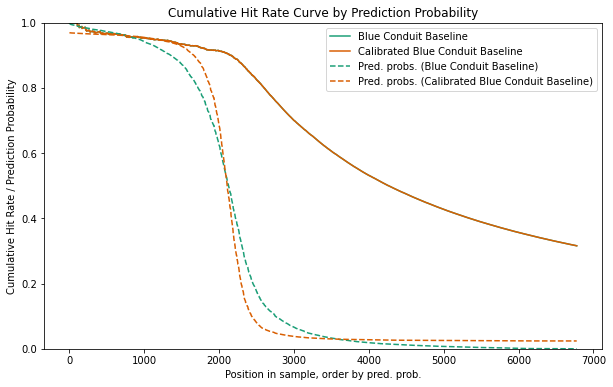

In [10]:
## Plots!
plot_hit_rate_curve(Ytest['dangerous'].astype(int), [yhat[:,1], yhat_cal[:,1]], 
                    labels=['Blue Conduit Baseline', 'Calibrated Blue Conduit Baseline'])

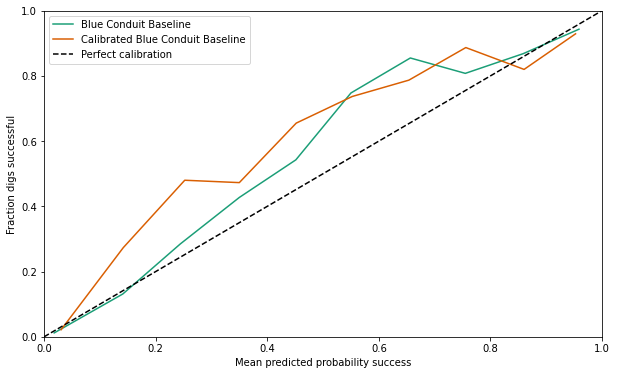

In [11]:
plot_calibration_curve(Ytest['dangerous'].astype(int), [yhat[:,1], yhat_cal[:,1]], 
                    labels=['Blue Conduit Baseline', 'Calibrated Blue Conduit Baseline'])

## Multiple models together

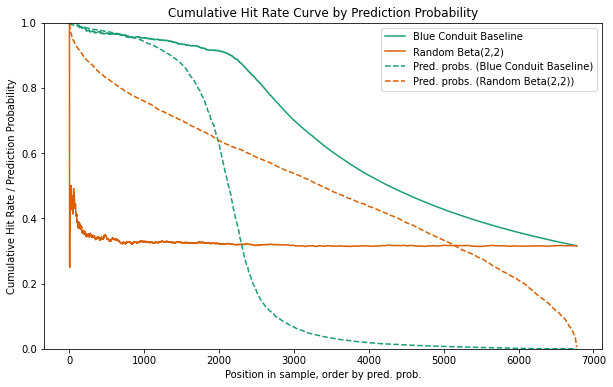

In [12]:
mod_list = [yhat[:,1], 
          np.random.beta(a=2, b=2, size=len(yhat[:,1]))]

plot_hit_rate_curve(Ytest['dangerous'].astype(int), mod_list, labels=['Blue Conduit Baseline', 'Random Beta(2,2)'])

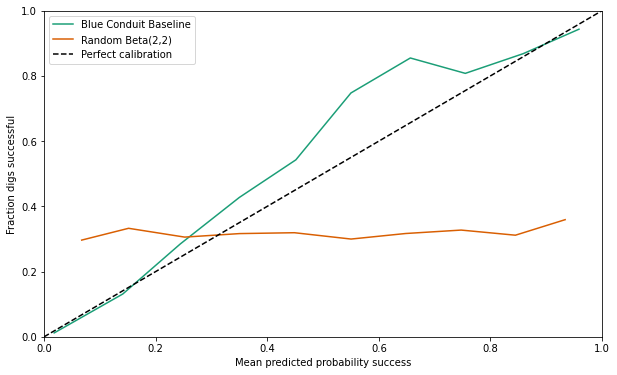

In [13]:
plot_calibration_curve(Ytest['dangerous'].astype(int), mod_list, labels=['Blue Conduit Baseline', 'Random Beta(2,2)'])

## Prediction probabilities
The `plot_probs` argument can be set to false to get only the hit rate curve.

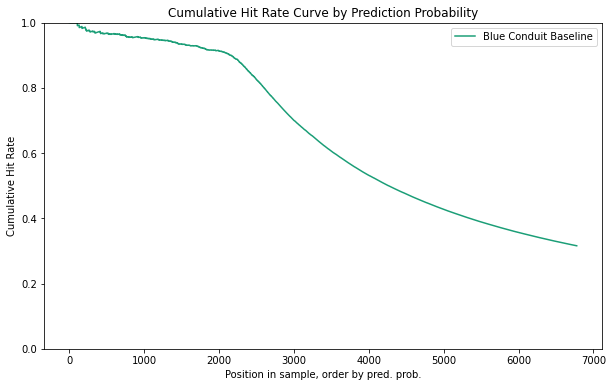

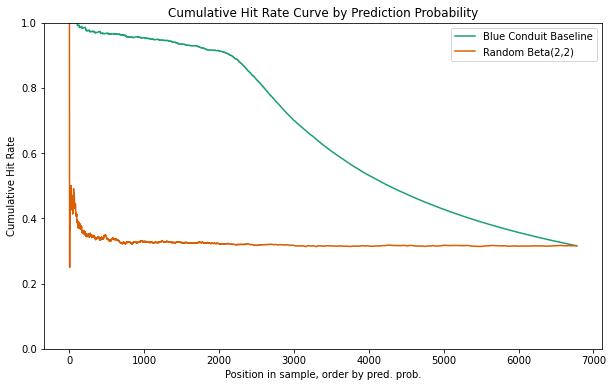

In [14]:
plot_hit_rate_curve(Ytest['dangerous'].astype(int), yhat[:,1], labels=['Blue Conduit Baseline'], plot_probs=False)
plot_hit_rate_curve(Ytest['dangerous'].astype(int), mod_list, labels=['Blue Conduit Baseline', 'Random Beta(2,2)'], 
                    plot_probs=False)

## Maximum performance
Because there is a set amount of lead in the data, a "perfect" model will still not maintain a hit rate of 100%. For a perfect classifer, the hit rate will be 100% until it reaches the position in the sample where there is no more lead, and will then decrease linearly until reaching the population total. To visualize this, we can set `max_perf = True` in the function call.

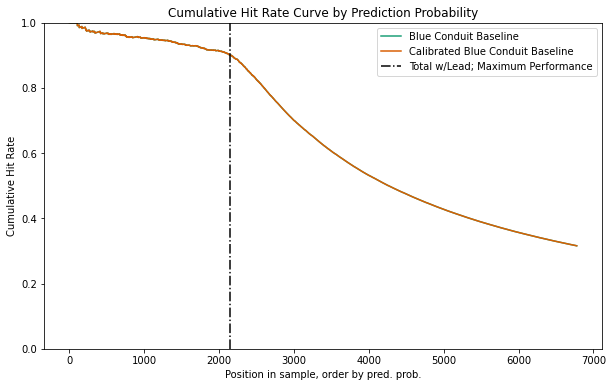

In [15]:
plot_hit_rate_curve(Ytest['dangerous'].astype(int), [yhat[:,1], yhat_cal[:,1]], 
                    labels=['Blue Conduit Baseline', 'Calibrated Blue Conduit Baseline'], 
                    plot_probs=False, max_perf=True)

## Ordering by prediction probability
Ordering by the cumulative number in the sample may not represent the different prediction probabilities in a model and its uncertainty. This is particularly true for the baseline models, which typically express greater uncertainty. To "fix" the classification threshold, the `order_by_prob = True` parameter can be passed.


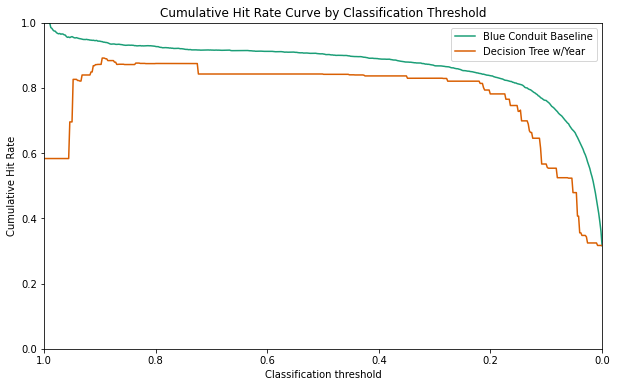

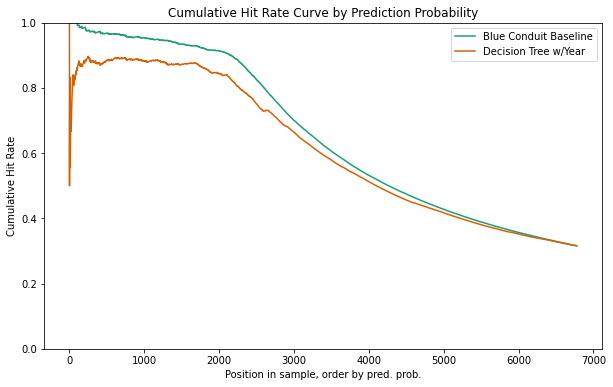

In [16]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(Xtrain['Year Built'].values.reshape(-1,1), Ytrain["dangerous"].values)
dtc_test_preds = dtc.predict_proba(Xtest['Year Built'].values.reshape(-1,1))
mod_list = [yhat[:,1], dtc_test_preds]

plot_hit_rate_curve(Ytest['dangerous'].astype(int), mod_list, labels=['Blue Conduit Baseline', 'Decision Tree w/Year'], 
                    plot_probs=False, order_by_prob=True)
plot_hit_rate_curve(Ytest['dangerous'].astype(int), mod_list, labels=['Blue Conduit Baseline', 'Decision Tree w/Year'], 
                    plot_probs=False, order_by_prob=False)